<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_palanquero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
from functools import reduce
from math import cos, sin, atan, pi
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'palanquero'
FILE_DATOS_ESTACION = 'eventos_palanquero_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = ['pwv']
LISTA_VAR_10M = ['viento', 'prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]

Cargando datos de Temp, Hum, Pres

In [77]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [78]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [79]:
dfPWV = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + FILES_PWV[0],
                  sep = ';', 
                )

dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()
dfPWV = dfPWV.loc[~dfPWV['PWV'].isnull()].reset_index(drop = True)

dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [97]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [183]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO']))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO']))

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean', 'PREC' : 'sum' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

df10mean = df10m.groupby('HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean', 'PREC' : 'mean'}).reset_index()

columns_10mean = [col for col in df10mean.columns if col != 'HORA']

for col in columns_10mean:
  df10mean = df10mean.rename(columns={col : f'{col}_mean'})

# df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
df10mean

,HORA,X_VIENTO_mean,Y_VIENTO_mean,PREC_mean
0,00,0.096019,0.048253,0.443132
1,01,0.068296,0.054684,0.454668
2,02,0.039724,0.055079,0.410362
3,03,0.055374,0.054708,0.425730
4,04,0.053402,0.047289,0.289768
5,05,0.028347,0.048418,0.196706
6,06,0.011407,0.032569,0.158510
7,07,-0.054599,0.028279,0.128564
8,08,-0.080722,-0.052329,0.104323
9,09,-0.028074,-0.116825,0.106955


## Cruzamiento de datos de Temp, hum y pres con PWV

In [155]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean,PWV_mean
0,00,24.602023,93.996656,990.357252,55.670397
1,01,24.310280,94.871467,989.928955,55.334776
2,02,24.065277,95.213324,989.517105,54.783669
3,03,23.824669,95.952575,989.360551,54.348051
4,04,23.624545,95.860717,989.524463,53.916396
5,05,23.476396,96.446680,989.957486,53.633150
6,06,23.392489,96.118200,990.549096,53.486145
7,07,24.552886,94.378837,991.286165,53.349843
8,08,26.403856,86.492383,991.815086,53.023588
9,09,28.146848,79.125812,991.753458,52.845932


In [147]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627
1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627
2,2011-05-13 22:00:00-05:00,2011-05-13 22:20:00-05:00,187.8,-74.693,5.627
3,2011-06-06 22:00:00-05:00,2011-06-06 22:20:00-05:00,198.5,-74.693,5.484
4,2011-11-03 02:00:00-05:00,2011-11-03 02:20:00-05:00,191.9,-74.693,5.484
5,2011-11-06 03:00:00-05:00,2011-11-06 02:40:00-05:00,196.4,-74.693,5.627
6,2011-11-28 05:00:00-05:00,2011-11-28 04:40:00-05:00,227.3,-74.693,5.341
7,2011-12-11 03:00:00-05:00,2011-12-11 02:40:00-05:00,199.3,-74.693,5.484
8,2012-03-16 23:00:00-05:00,2012-03-16 22:40:00-05:00,193.6,-74.693,5.484
9,2012-03-20 23:00:00-05:00,2012-03-20 23:20:00-05:00,196.1,-74.693,5.627


In [148]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 6
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:00:00-05:00,-6.0
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:00:00-05:00,-5.0
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0
5,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0
6,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0
7,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 00:00:00-05:00,1.0
8,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 01:00:00-05:00,2.0
9,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 02:00:00-05:00,3.0


In [151]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [150]:
dfAnomalia

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                      mean       std  ...              std         mean       std
0       -6.0      0.053972  1.557917  ...         1.145694     2.152636  4.395274
1       -5.0      0.108399  1.632155  ...         1.125976     2.183125  4.095265
2       -4.0      0.226235  1.320779  ...         1.224394     2.751677  3.771588
3       -3.0      0.349964  1.188915  ...         1.305966     3.256764  3.426964
4       -2.0      0.457180  1.135485  ...         1.511063     3.491419  3.138265
5       -1.0      0.393037  1.078524  ...         1.619211     3.484668  3.009741
6        0.0      0.120684  1.257764  ...         1.795704     2.735343  3.064673
7        1.0     -0.439633  1.242426  ...         1.762536     1.788008  2.997425
8        2.0     -0.531372  1.141707  ...         1.902275     1.628800  2.942431
9        3.0     -0.410947  0.987293  ...         1.845615     1.952666  3.021484
10       4.0     -0.524259  1.023989  ...         1.892017     2.064888  3.072541
11       5.0     -0.620014  1.456220  ...         1.886782     2.352379  2.969057
12       6.0     -0.558957  1.609900  ...         1.850859     2.493826  3.101611

[13 rows x 9 columns]

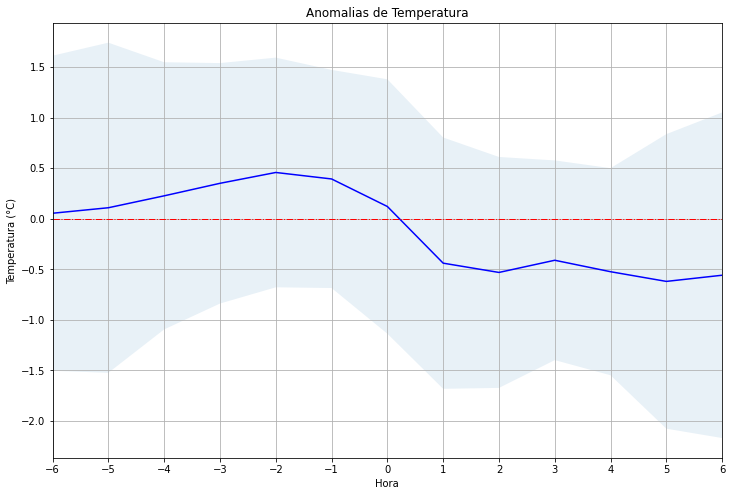

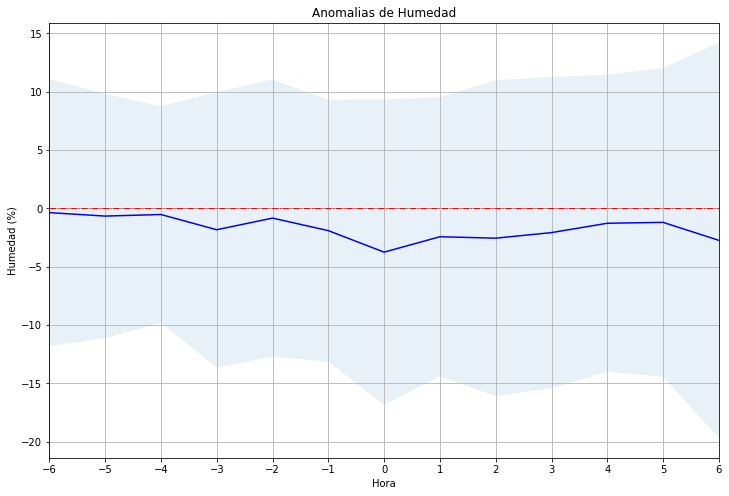

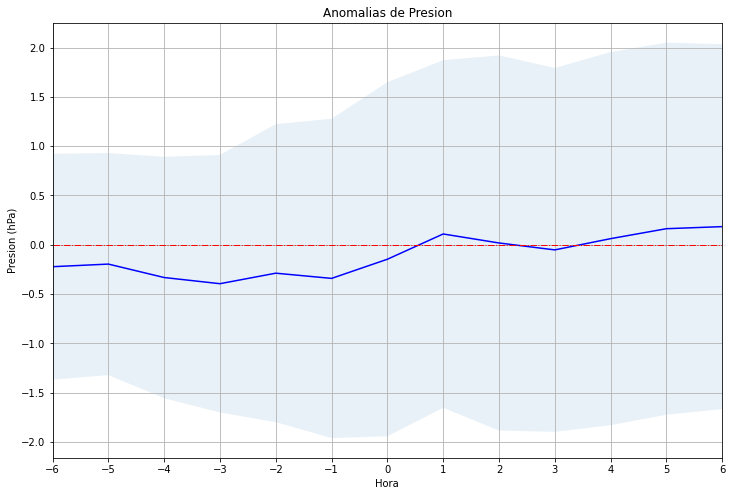

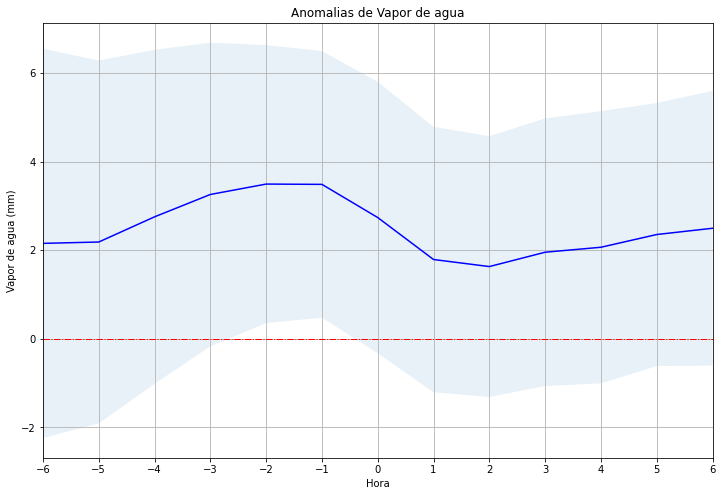

In [86]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'])
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Hora")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_{int_horas}h.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_{int_horas}h.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_{int_horas}h.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# dfAnomalia

## Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [87]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,PWV,NUMERO_VARS
6,2011-01-27 23:00:00-05:00,224.2,0,23.7,92.0,990.2,53.538182,4
19,2011-04-09 23:00:00-05:00,197.0,1,23.8,98.0,992.4,59.495455,4
32,2011-05-13 22:00:00-05:00,187.8,2,24.1,100.0,991.8,61.653636,4
45,2011-06-06 22:00:00-05:00,198.5,3,NaN,NaN,NaN,NaN,0
58,2011-11-03 02:00:00-05:00,191.9,4,25.6,NaN,988.4,56.503636,3
71,2011-11-06 03:00:00-05:00,196.4,5,23.7,NaN,988.9,59.640909,3
84,2011-11-28 05:00:00-05:00,227.3,6,NaN,NaN,NaN,NaN,0
97,2011-12-11 03:00:00-05:00,199.3,7,NaN,NaN,NaN,NaN,0
110,2012-03-16 23:00:00-05:00,193.6,8,NaN,NaN,NaN,NaN,0
123,2012-03-20 23:00:00-05:00,196.1,9,NaN,NaN,NaN,NaN,0


In [88]:
dfEventos0.count()

FECHA_EVENTO    51
min_t           51
index           51
TEMP            36
HUM             26
PRESION         36
PWV             32
NUMERO_VARS     51
dtype: int64

In [89]:
dfEventos0['NUMERO_VARS'].value_counts()

4    21
3    15
0    14
1     1
Name: NUMERO_VARS, dtype: int64

In [90]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 4]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                      mean       std  ...              std         mean       std
0       -6.0      0.306419  1.441564  ...         1.181391     1.394179  5.106512
1       -5.0      0.335481  1.858394  ...         1.068100     1.582354  4.735274
2       -4.0      0.219070  1.426882  ...         1.274862     2.083443  4.428076
3       -3.0      0.313941  1.329001  ...         1.250502     2.602140  3.969517
4       -2.0      0.277828  1.217523  ...         1.400386     2.868742  3.607619
5       -1.0      0.324550  1.136754  ...         1.531643     2.867482  3.493517
6        0.0      0.249711  1.316245  ...         1.590972     2.303907  3.536191
7        1.0     -0.401300  1.337328  ...         1.584790     1.286131  3.239916
8        2.0     -0.538283  1.121891  ...         1.755924     0.846929  2.867861
9        3.0     -0.493410  0.949121  ...         1.657401     1.129143  3.184373
10       4.0     -0.752072  0.984212  ...         1.696372     1.101938  3.227764
11       5.0     -0.862691  1.538343  ...         1.686539     1.371303  3.019227
12       6.0     -0.598337  1.839214  ...         1.770564     1.327794  2.917266

[13 rows x 9 columns]

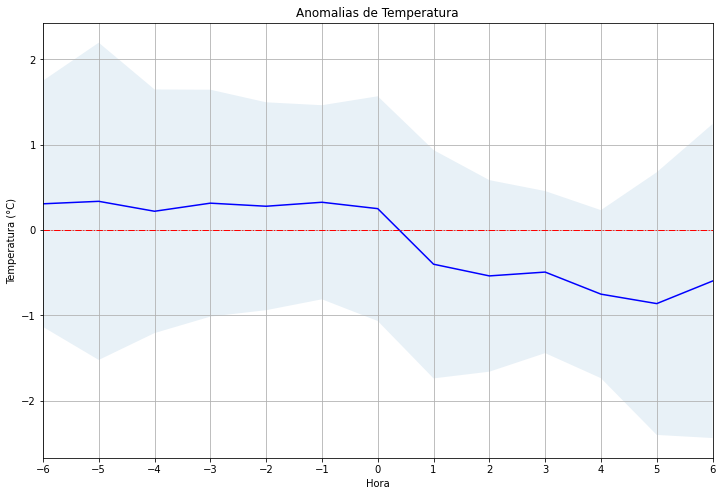

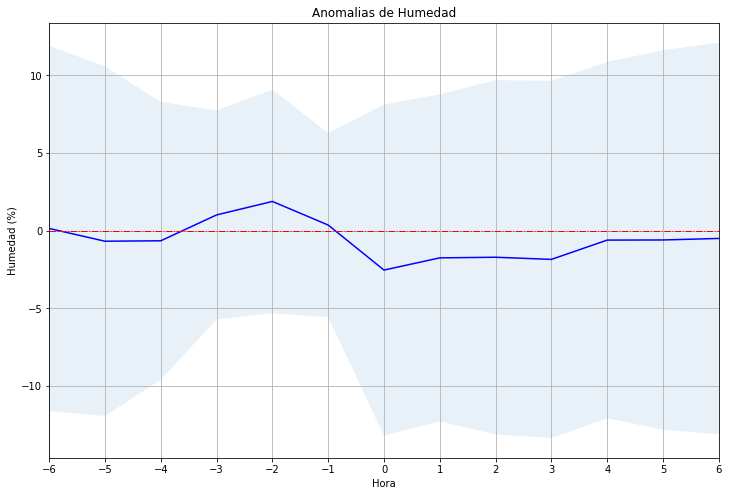

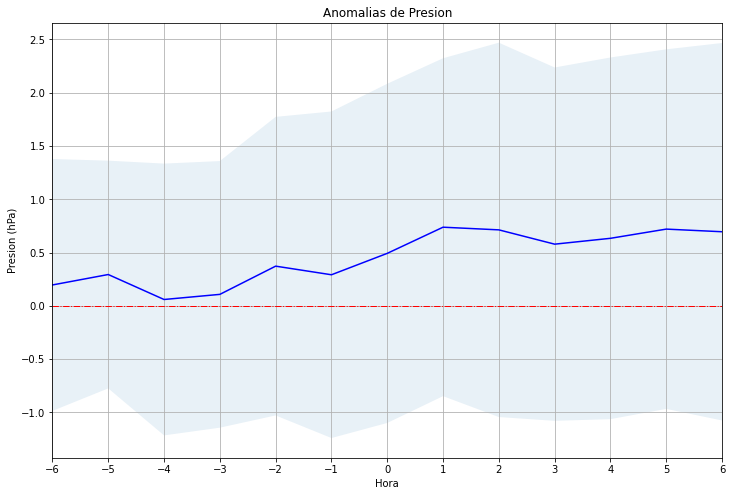

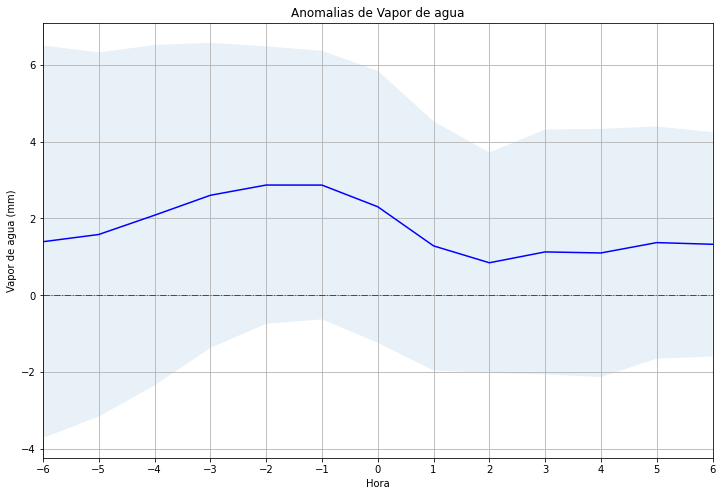

In [91]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_{int_horas}h.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_{int_horas}h.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_{int_horas}h.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

## Análisis para Dirección del Viento 

In [190]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[y], df[x])) if np.arctan2(df[y], df[x]) > 0 else 360 + np.rad2deg(np.arctan2(df[y], df[x]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

In [197]:
df10mean

,HORA,X_VIENTO_mean,Y_VIENTO_mean,PREC_mean,DIRVIENTO_mean,VELVIENTO_mean
0,00,0.096019,0.048253,0.443132,26.681150,0.107461
1,01,0.068296,0.054684,0.454668,38.684132,0.087491
2,02,0.039724,0.055079,0.410362,54.199677,0.067909
3,03,0.055374,0.054708,0.425730,44.653418,0.077841
4,04,0.053402,0.047289,0.289768,41.526046,0.071330
5,05,0.028347,0.048418,0.196706,59.652463,0.056106
6,06,0.011407,0.032569,0.158510,70.697448,0.034509
7,07,-0.054599,0.028279,0.128564,152.618591,0.061488
8,08,-0.080722,-0.052329,0.104323,212.953744,0.096200
9,09,-0.028074,-0.116825,0.106955,256.487648,0.120151


In [194]:
dfCross10m = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')
dfCross10m['HORA'] = dfCross10m['FECHA'].apply(lambda x: x[11:13])
dfCross10m = pd.merge(dfCross10m, df10mean, on = 'HORA', how='left')

list_anomalias_10m = []
for col in ['DIRVIENTO', 'VELVIENTO']:
  anomalia = f'{col}_anomalia'
  list_anomalias_10m.append(anomalia)
  dfCross10m[anomalia] = dfCross10m[f'{col}'] - dfCross10m[f'{col}_mean'] 

func_norm_360 = lambda df, x : df[x] + 360 if df[x] < 0 else df[x]
dfCross10m['DIRVIENTO_anomalia'] = dfCross10m.apply(func_norm_360, x = 'DIRVIENTO_anomalia', axis=1)
dfCross10m
# dfAnomalia_10m = dfCross10m[list_anomalias_10m + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

# dfAnomalia_10m

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,PREC,HORA,DIRVIENTO,VELVIENTO,X_VIENTO_mean,Y_VIENTO_mean,PREC_mean,DIRVIENTO_mean,VELVIENTO_mean,DIRVIENTO_anomalia,VELVIENTO_anomalia
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:00:00-05:00,-6.0,2011-01-27 17,0.262585,0.129298,0.0,17,26.215765,0.292693,0.660201,-0.010368,0.041641,359.100290,0.660282,27.115475,-0.367590
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:00:00-05:00,-5.0,2011-01-27 18,0.286845,0.085277,0.0,18,16.556855,0.299253,0.472596,0.041434,0.071837,5.010473,0.474409,11.546382,-0.175156
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0,2011-01-27 19,0.139930,0.003839,0.0,19,1.571393,0.139983,0.293920,0.014530,0.093401,2.830114,0.294279,358.741279,-0.154296
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0,2011-01-27 20,0.116156,0.005777,0.0,20,2.847375,0.116300,0.223311,0.017385,0.061285,4.451663,0.223987,358.395712,-0.107687
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0,2011-01-27 21,0.129471,0.035036,0.0,21,15.142119,0.134127,0.140521,0.044617,0.281356,17.615094,0.147434,357.527024,-0.013307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 03:00:00-05:00,2.0,2017-11-14 03,0.607192,0.239530,0.1,03,21.528600,0.652730,0.055374,0.054708,0.425730,44.653418,0.077841,336.875182,0.574889
659,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:00:00-05:00,3.0,2017-11-14 04,-0.552925,0.786721,0.0,04,125.100419,0.961590,0.053402,0.047289,0.289768,41.526046,0.071330,83.574373,0.890260
660,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 05:00:00-05:00,4.0,2017-11-14 05,0.777300,-0.519019,0.0,05,326.268155,0.934653,0.028347,0.048418,0.196706,59.652463,0.056106,266.615692,0.878547
661,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 06:00:00-05:00,5.0,2017-11-14 06,1.823041,-0.158302,0.1,06,355.037210,1.829901,0.011407,0.032569,0.158510,70.697448,0.034509,284.339762,1.795392


In [199]:
26.215765 - 359.100290 	+ 360

27.115475000000004